## Libraries and Dependencies ##

In [1]:
from datetime import datetime, timedelta
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import yfinance as yf

## Getting the Data ##

In [2]:
# Connecting to finviz.com to scrape the data on Stock News
#base URL
finviz_url = 'https://finviz.com/quote.ashx?t='
#List of stocks to be analyzed
tickers = ['AMZN', 'GOOG', 'AAPL', 'JPM', 'JNJ', 'XOM', 'F', 'DIS', 'CVX', 'UL']

In [3]:
#Pulling the data 
news_tables = {}
for ticker in tickers:
    #creating the URL for the request
    url = finviz_url + ticker
    #request
    response = requests.get(url=url, headers={'user-agent': 'my_app'})
    #parsing using BeautifulSoup
    html = BeautifulSoup(response.text, 'html')
    #looking for 'news-table' (the table on the webpage containing the news)
    #store the table with the news in the variable news_table
    news_table = html.find(id='news-table')
    #adds a key(stock ticker) and a value (the news table) to the news_table dictionary
    news_tables[ticker] = news_table
   
#Find the news title in every table row    
parsed_data = []

for ticker, news_table in news_tables.items():
      #find all the <tr> - table row containing the news title
      for row in news_table.findAll('tr'):
                       
             #Find <a> tag (containing title of the article)  and extract the title        
             title = row.find('a')
             if title:
               title = title.text 
             #if there is no title print "No article found"  
             else:
                print("No article link found.")
             #Extract the date and time from the <td> tag
             date_data=[]
             date_data =row.find('td').get_text(strip=True).split(' ')
            
                                    
             if len(date_data) == 1:
                time = date_data[0]
             else:
                if date_data[0] == 'Today': 
                    date = datetime.now().date()
                    time = date_data[1]
                else:
                    date = date_data[0]
                    time = date_data[1]
             #Add the ticker, title, date, and time to the the parsed_data list
             parsed_data.append([ticker, date, time, title])
print (parsed_data)
print(len(parsed_data))
      

No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
No article link found.
[['AMZN', datetime.date(2024, 10, 16), '06:53PM', 'Election cybersecurity, AI in healthcare: Asking for a Trend'], ['AMZN', datetime.date(2024, 10, 16), '06:11PM', 'These Mag 7 giants continue to invest even more in AI: Chart'], ['AMZN', datetime.date(2024, 10, 16), '05:09PM', 'Amazon invests $500M to go nucl

# Creating the dataframe and cleaning it up #

In [4]:
#Creating a dataframe from the parsed_data list
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
# CLEANING THE DATA *************************************************** 
#1. Deleting the rows that don't contain a title
df = df.dropna(subset=['title'])
#Normalizing the date format
df['date'] = pd.to_datetime(df['date']).dt.date
#create a file with the data to inspect it
df.to_csv('parsed_data.csv')
df.head(10)



,ticker,date,time,title
0,AMZN,2024-10-16,06:53PM,"Election cybersecurity, AI in healthcare: Aski..."
1,AMZN,2024-10-16,06:11PM,These Mag 7 giants continue to invest even mor...
2,AMZN,2024-10-16,05:09PM,Amazon invests $500M to go nuclear after Micro...
3,AMZN,2024-10-16,04:29PM,Amazon doubles down on nuclear energy with dea...
4,AMZN,2024-10-16,04:13PM,"Amazon Goes Nuclear, Sending IBD's Stock Of Th..."
6,AMZN,2024-10-16,03:50PM,AWS CEO on Amazon's $500 million small modular...
7,AMZN,2024-10-16,03:45PM,Nvidia is set to dominate another Big Tech ear...
8,AMZN,2024-10-16,03:36PM,"Jim Cramer on Amazon, Inc. (AMZN): I Think The..."
9,AMZN,2024-10-16,02:45PM,How to gain 'Magnificent Seven' exposure throu...
10,AMZN,2024-10-16,02:40PM,"Amazon, Google tap into nuclear power to fuel ..."


In [5]:
#run the sentiment analysis on the titles 
vader = SentimentIntensityAnalyzer()
f = lambda title: vader.polarity_scores(title)['compound'] if title is not None else None
df['score'] = df['title'].apply(f)
df.to_csv('scores.csv')
df.head(10) 


,ticker,date,time,title,score
0,AMZN,2024-10-16,06:53PM,"Election cybersecurity, AI in healthcare: Aski...",0.0000
1,AMZN,2024-10-16,06:11PM,These Mag 7 giants continue to invest even mor...,0.0000
2,AMZN,2024-10-16,05:09PM,Amazon invests $500M to go nuclear after Micro...,0.1779
3,AMZN,2024-10-16,04:29PM,Amazon doubles down on nuclear energy with dea...,0.4215
4,AMZN,2024-10-16,04:13PM,"Amazon Goes Nuclear, Sending IBD's Stock Of Th...",0.1779
6,AMZN,2024-10-16,03:50PM,AWS CEO on Amazon's $500 million small modular...,0.0000
7,AMZN,2024-10-16,03:45PM,Nvidia is set to dominate another Big Tech ear...,-0.1280
8,AMZN,2024-10-16,03:36PM,"Jim Cramer on Amazon, Inc. (AMZN): I Think The...",0.6124
9,AMZN,2024-10-16,02:45PM,How to gain 'Magnificent Seven' exposure throu...,0.8074
10,AMZN,2024-10-16,02:40PM,"Amazon, Google tap into nuclear power to fuel ...",0.1779


### Creating Scores Charts ###

In [6]:
#Filter the news going back maximum 7 days
week_news_df = df[df['date'] >= (datetime.now().date() - timedelta(days = 7))]

#calculate the average score for each day, and store it in a dataframe
mean_df = week_news_df.groupby(['ticker', 'date']).mean('score')
mean_df = mean_df.unstack()
mean_df = mean_df.xs('score', axis='columns').transpose()

#export to file
mean_df.to_csv('sentiment_scores.csv')
#print the dataframe
mean_df.head(20)

ticker,AAPL,AMZN,CVX,DIS,F,GOOG,JNJ,JPM,UL,XOM
date,,,,,,,,,,
2024-10-09,NaN,NaN,0.320733,-0.021871,NaN,NaN,0.114380,NaN,NaN,0.273200
2024-10-10,NaN,NaN,0.000000,0.006450,0.273200,NaN,0.067914,0.333763,-0.07400,0.261717
2024-10-11,0.142044,0.353600,-0.013600,NaN,NaN,NaN,0.147020,0.114065,-0.08785,0.103775
2024-10-12,0.190333,0.091564,0.000000,0.000000,0.510600,0.161660,0.636900,0.094700,NaN,0.000000
2024-10-13,0.190025,0.252220,0.259975,NaN,0.227350,0.367775,0.000000,NaN,NaN,-0.136600
2024-10-14,0.203427,0.353969,NaN,0.313133,0.206800,0.158183,0.136000,0.226392,-0.36010,0.101150
2024-10-15,0.163126,0.114288,0.474025,-0.285950,0.198137,0.082525,0.076482,0.124570,NaN,0.179700
2024-10-16,0.125483,0.206545,0.233225,0.178625,0.000000,0.282529,0.044867,0.044033,NaN,0.218200


In [7]:
for ticker in tickers:
    if ticker in mean_df.columns:
        print(f"Renaming {ticker} to {ticker}_score")
        mean_df.rename(columns={ticker: ticker + '_score'}, inplace=True)
    else:
        print(f"{ticker} not found in DataFrame columns.")

Renaming AMZN to AMZN_score
Renaming GOOG to GOOG_score
Renaming AAPL to AAPL_score
Renaming JPM to JPM_score
Renaming JNJ to JNJ_score
Renaming XOM to XOM_score
Renaming F to F_score
Renaming DIS to DIS_score
Renaming CVX to CVX_score
Renaming UL to UL_score


In [8]:
print(mean_df.columns)

Index(['AAPL_score', 'AMZN_score', 'CVX_score', 'DIS_score', 'F_score',
       'GOOG_score', 'JNJ_score', 'JPM_score', 'UL_score', 'XOM_score'],
      dtype='object', name='ticker')


In [9]:

# #plt.figure(figsize=(10,8))
# mean_df = df.groupby(['ticker', 'date']).mean('score')
# mean_df = mean_df.unstack()

# mean_df = mean_df.xs('score', axis='columns').transpose()
# #mean_df.groupby('date')['score'].mean().unstack()
# today = datetime.now().date()
# scores_file_name = 'scores_' + str(today)
# # Assuming the original score columns are just named by tickers
# for ticker in tickers:
#     mean_df.rename(columns={ticker: ticker + '_score'}, inplace=True)

# mean_df.to_csv(scores_file_name +'.csv')
# mean_df.head(100)

<Figure size 10000x5000 with 0 Axes>

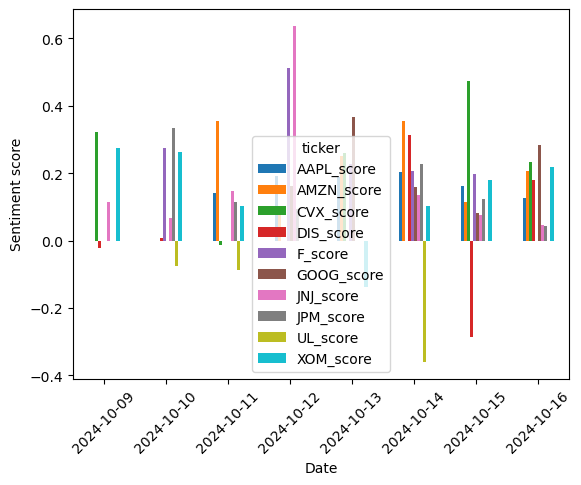

In [10]:
plt.figure(figsize=(100, 50))
mean_df.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.xticks(rotation=45)
plt.show()

# Stock prices using YF Library 

In [11]:
start_date = mean_df.index.min()
end_date = mean_df.index.max()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# end_date = datetime.now()
# start_date = end_date - timedelta(days=7)

In [12]:
def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data

In [13]:
def plot_data(data):
    fig, axes = plt.subplots(nrows=len(tickers), figsize=(10, 15))
    fig.suptitle('Stock Prices and Volumes Over the Last Week', fontsize=16)
    
    for i, ticker in enumerate(tickers):
        ax1 = axes[i]
        color1 = 'tab:blue'
        ax1.plot(data['Close'][ticker], label=f'{ticker} Price', color=color1)
        ax1.set_title(f'{ticker} Stock Price and Volume')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Adjusted Close Price', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.legend(loc='upper left')
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color2 = 'tab:orange'
        ax2.plot(data['Volume'][ticker], label=f'{ticker} Volume', color=color2)
        ax2.set_ylabel('Volume', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


[*********************100%***********************]  10 of 10 completed


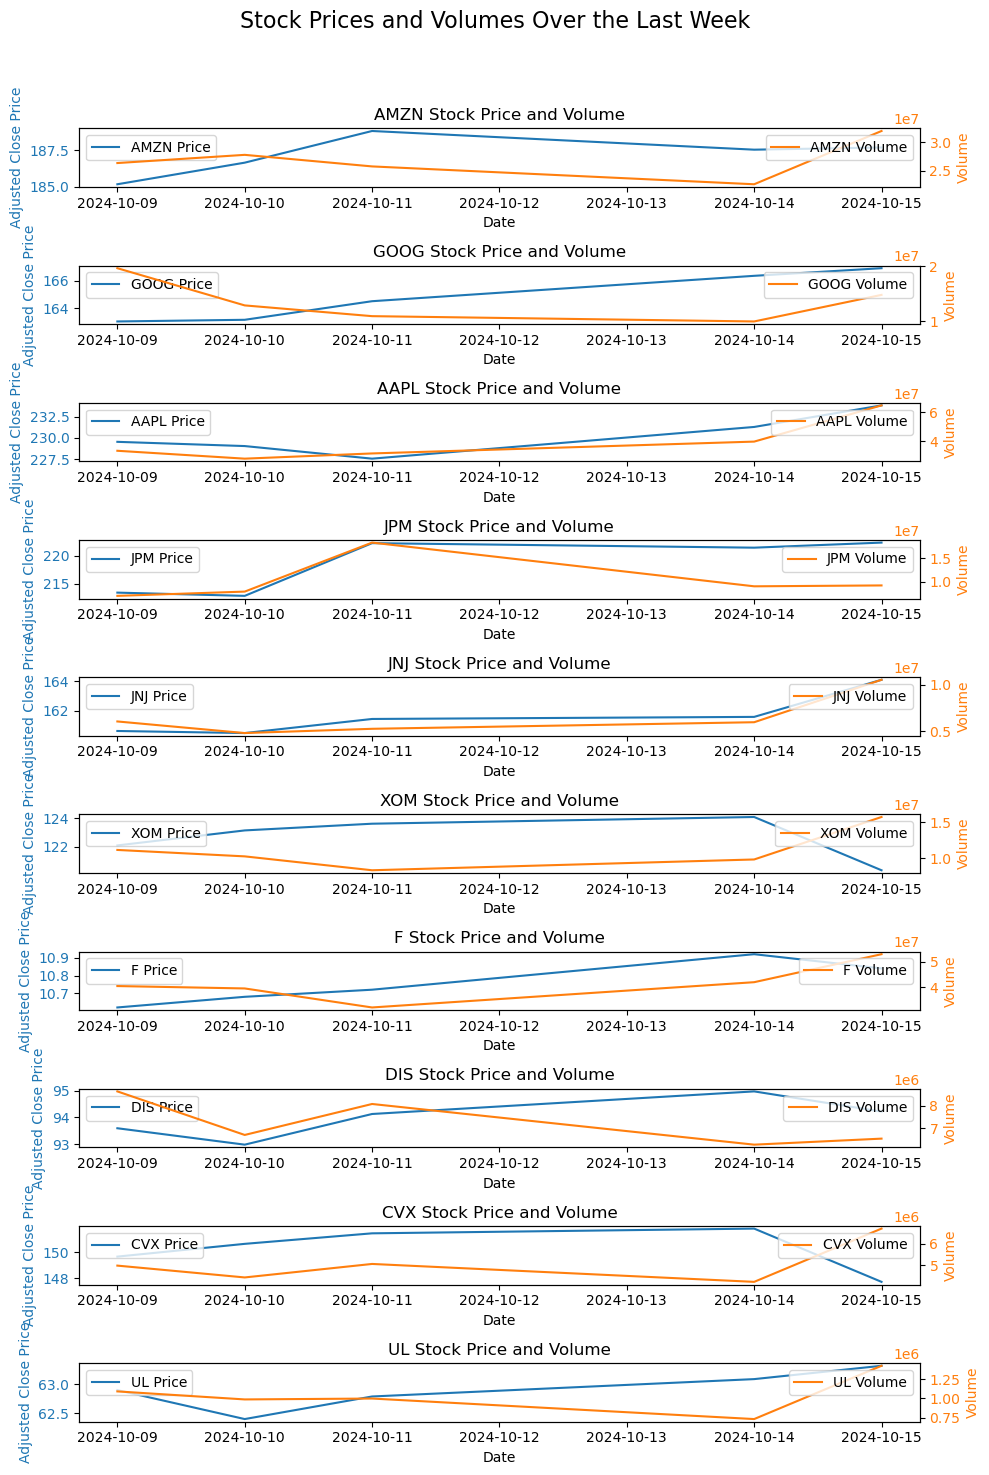

In [14]:
def main():
    stock_data = fetch_data(tickers, start_date, end_date)
    plot_data(stock_data)

if __name__ == '__main__':
    main()

# combine info


In [15]:
start_date = mean_df.index.min()
end_date = mean_df.index.max()
print(f"Fetching data from {start_date} to {end_date}")

Fetching data from 2024-10-09 to 2024-10-16


In [16]:
# Download stock price data
#stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
stock_data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [17]:
stock_data.index = stock_data.index.tz_localize(None)

In [18]:
mean_df.index = pd.to_datetime(mean_df.index)
stock_data.index = pd.to_datetime(stock_data.index)

In [19]:
# Merge and check columns
merged_df = pd.merge(mean_df, stock_data, left_index=True, right_index=True, how='inner')
print(merged_df.columns)  # This will let you see all column names

Index(['AAPL_score', 'AMZN_score', 'CVX_score', 'DIS_score', 'F_score',
       'GOOG_score', 'JNJ_score', 'JPM_score', 'UL_score', 'XOM_score', 'AAPL',
       'AMZN', 'CVX', 'DIS', 'F', 'GOOG', 'JNJ', 'JPM', 'UL', 'XOM'],
      dtype='object')


In [20]:

# fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(10, 6 * len(tickers)))

# # Ensure 'axes' is always an array, even if there's only one subplot
# if len(tickers) == 1:
#     axes = [axes]

# for i, ticker in enumerate(tickers):
#     ax1 = axes[i]

#     # Plotting Scores
#     score_col = ticker + '_score'
#     if score_col in merged_df.columns:
#         ax1.plot(merged_df.index, merged_df[score_col], label=f'{ticker} Score', color='tab:red')
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel('Score', color='tab:red')
#     ax1.tick_params(axis='y', labelcolor='tab:red')
    
#     # Create a second y-axis for stock prices
#     ax2 = ax1.twinx()
#     if ticker in merged_df.columns:
#         ax2.plot(merged_df.index, merged_df[ticker], label=f'{ticker} Price', color='tab:blue')
#     ax2.set_ylabel('Stock Price', color='tab:blue')
#     ax2.tick_params(axis='y', labelcolor='tab:blue')
    
#     # Title and layout
#     ax1.set_title(f'{ticker} Score vs Price')
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

# fig.tight_layout()
#plt.show()



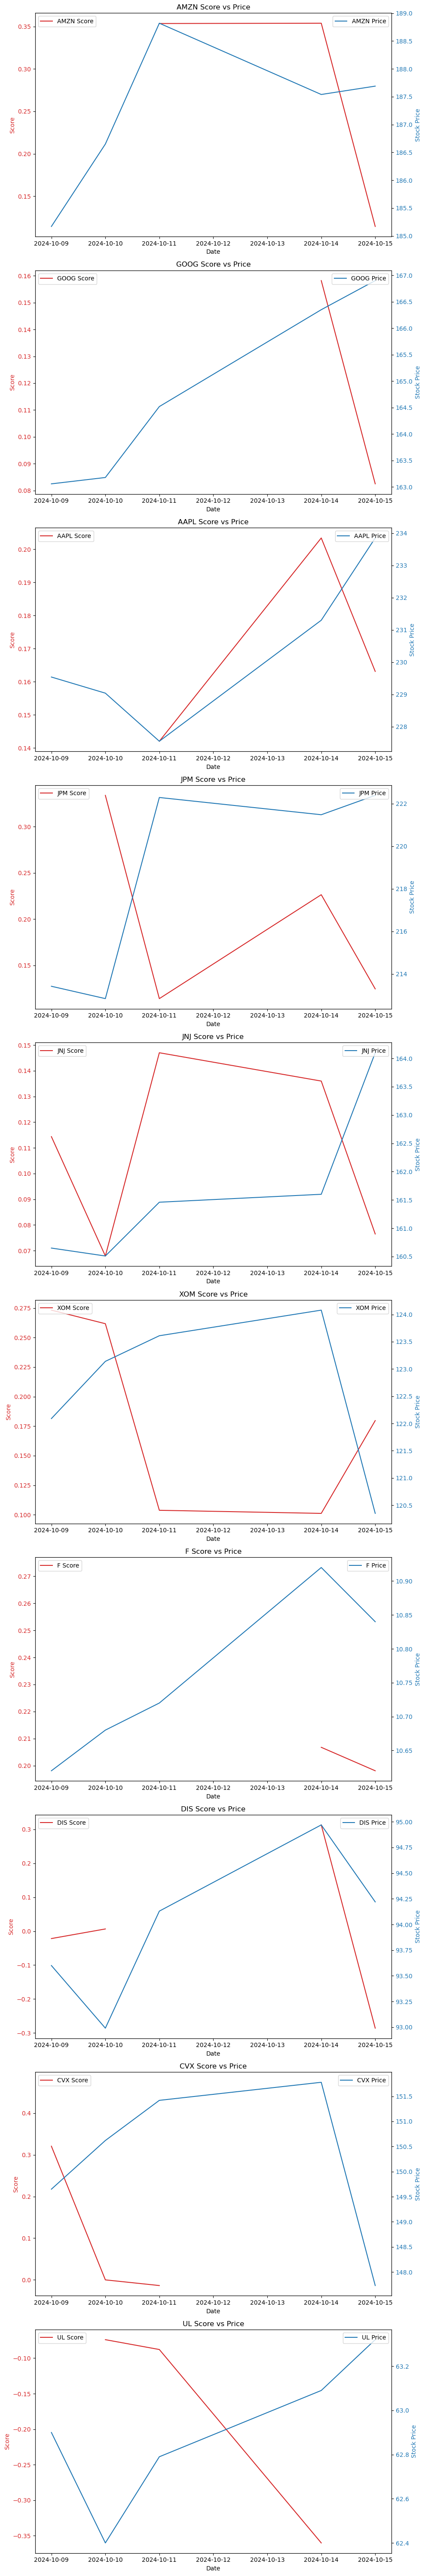

In [21]:
# Creating subplots
fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(10, 6 * len(tickers)))

# Ensure 'axes' is always an array, even if there's only one subplot
if len(tickers) == 1:
    axes = [axes]

for i, ticker in enumerate(tickers):
    ax1 = axes[i]

    # Plotting Scores
    score_col = ticker + '_score'
    if score_col in merged_df.columns and not merged_df[score_col].isna().all():
        ax1.plot(merged_df.index, merged_df[score_col], label=f'{ticker} Score', color='tab:red')
        ax1.legend(loc='upper left')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    # Create a second y-axis for stock prices
    ax2 = ax1.twinx()
    if ticker in merged_df.columns and not merged_df[ticker].isna().all():
        ax2.plot(merged_df.index, merged_df[ticker], label=f'{ticker} Price', color='tab:blue')
        ax2.legend(loc='upper right')

    ax2.set_ylabel('Stock Price', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Title for each subplot
    ax1.set_title(f'{ticker} Score vs Price')

fig.tight_layout()
plt.show()
